<a href="https://colab.research.google.com/github/chiranjeevi-manike/IBM-Cognitiveclass.ai/blob/main/Adult_Income_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics



def printmd(string):
    display(Markdown(string))
    
    
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


%  matplotlib inline

In [ ]:
#adult = pd.read_csv('adult.csv')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']

train = pd.read_csv('adult_data.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test = pd.read_csv('adult_test.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')


adult = pd.concat([test,train])
adult.reset_index(inplace = True, drop = True)

---
# 1. Preliminary Data Analysis

In [ ]:
# Setting all the categorical columns to type category
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')
    
printmd('## 1.1. Columns and their types')
print(adult.info())

## 1.1. Columns and their types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  int64   
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  int64   
 3   education        48842 non-null  category
 4   educational-num  48842 non-null  int64   
 5   marital-status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital-gain     48842 non-null  int64   
 11  capital-loss     48842 non-null  int64   
 12  hours-per-week   48842 non-null  int64   
 13  native-country   48842 non-null  category
 14  income           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None


In [ ]:
# Top 5 records
printmd('## 1.2. Data')
adult.head()

## 1.2. Data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
printmd('## 1.3. Summary Statistics')

adult.describe()

## 1.3. Summary Statistics

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
printmd('## 1.4. Missing values')
for i,j in zip(adult.columns,(adult.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        printmd(str(i) + ': ' + str(j) + ' records')



## 1.4. Missing values

workclass: 2799 records

occupation: 2809 records

native-country: 857 records

### Treating Missing Values by predicting them

I fill the missing values in each of the three columns by predicting their values. For each of the three columns, I use all the attributes (including 'income') as independent variables and treat that column as the dependent variable, making it a multi-class classification task. I use three classification algorithms, namely, logistic regression, decision trees and random forest to predict the class when the value is missing (in this case a '?'). I then take a majority vote amongst the three classifiers to be the class of the missing value. In case of a tie, I pick the majority class of that column using the entire dataset.

In [ ]:
# Create one hot encoding of the categorical columns in the data frame.
def oneHotCatVars(df, df_cols):
    
    df_1 = adult_data = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

In [ ]:
printmd('### 1.4.1. Filling in missing values for Attribute workclass')

test_data = adult[(adult.workclass.values == '?')].copy()
test_label = test_data.workclass

train_data = adult[(adult.workclass.values != '?')].copy()
train_label = train_data.workclass

test_data.drop(columns = ['workclass'], inplace = True)
train_data.drop(columns = ['workclass'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult.workclass.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.workclass.values == '?'),'workclass'] = overall_pred.values
print(adult.workclass.value_counts())
print(adult.workclass.unique())

### 1.4.1. Filling in missing values for Attribute workclass

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Private             36002
Self-emp-not-inc     3872
Local-gov            3138
State-gov            1981
Self-emp-inc         1696
Federal-gov          1432
Never-worked          700
Without-pay            21
?                       0
Name: workclass, dtype: int64
['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Never-worked', 'Without-pay']
Categories (8, object): ['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov',
                         'Self-emp-inc', 'Never-worked', 'Without-pay']


In [ ]:
printmd('### 1.4.2. Filling in missing values for Occupation occupation')

test_data = adult[(adult.occupation.values == '?')].copy()
test_label = test_data.occupation

train_data = adult[(adult.occupation.values != '?')].copy()
train_label = train_data.occupation

test_data.drop(columns = ['occupation'], inplace = True)
train_data.drop(columns = ['occupation'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult.occupation.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.occupation.values == '?'),'occupation'] = overall_pred.values
print(adult.occupation.value_counts())
print(adult.occupation.unique())

### 1.4.2. Filling in missing values for Occupation occupation

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Prof-specialty       7739
Craft-repair         6555
Exec-managerial      6141
Adm-clerical         5866
Sales                5612
Other-service        5126
Machine-op-inspct    3070
Transport-moving     2397
Handlers-cleaners    2108
Farming-fishing      1508
Tech-support         1461
Protective-serv       989
Priv-house-serv       255
Armed-Forces           15
?                       0
Name: occupation, dtype: int64
['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', 'Prof-specialty', 'Other-service', ..., 'Sales', 'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces']
Length: 14
Categories (14, object): ['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', 'Prof-specialty', ...,
                          'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces']


In [ ]:
printmd('### 1.4.3. Filling in missing values for Native Country')

test_data = adult[(adult['native-country'].values == '?')].copy()
test_label = test_data['native-country']

train_data = adult[(adult['native-country'].values != '?')].copy()
train_label = train_data['native-country']

test_data.drop(columns = ['native-country'], inplace = True)
train_data.drop(columns = ['native-country'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult['native-country'].value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult['native-country'].values == '?'),'native-country'] = overall_pred.values
print(adult['native-country'].value_counts())
print(adult['native-country'].unique())

### 1.4.3. Filling in missing values for Native Country

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


United-States                 44646
Mexico                          961
Philippines                     305
Germany                         206
Puerto-Rico                     184
Canada                          182
India                           156
El-Salvador                     155
Cuba                            138
England                         127
China                           127
South                           120
Jamaica                         106
Italy                           105
Dominican-Republic              104
Japan                            95
Guatemala                        88
Vietnam                          88
Poland                           87
Columbia                         85
Haiti                            75
Portugal                         68
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador                     

In [ ]:
# Resetting the categories

adult['workclass'] = adult['workclass'].cat.remove_categories('?')
adult['occupation'] = adult['occupation'].cat.remove_categories('?')
adult['native-country'] = adult['native-country'].cat.remove_categories('?')



In [ ]:
printmd('## 1.5. Correlation Matrix')

display(adult.corr())

printmd('We see that none of the columns are highly correlated.')

## 1.5. Correlation Matrix

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
educational-num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
capital-gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
capital-loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
hours-per-week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


We see that none of the columns are highly correlated.

---
# 2. Exploratory Analysis

In [ ]:
# Creating a dictionary that contain the education and it's corresponding education level
edu_level = {}
for x,y in adult[['educational-num','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x

## 2.1. Education vs Income

I plot a bar graph showing the proportion of income classes across education levels         in the figure below. As one would expect, we see from the bar graph below that as the         education level increase, the proportion of people who earn more than 50k a year also         increase. It is interesting to note that only after a master's degree, the proportion of         people earning more than 50k a year, is a majority.

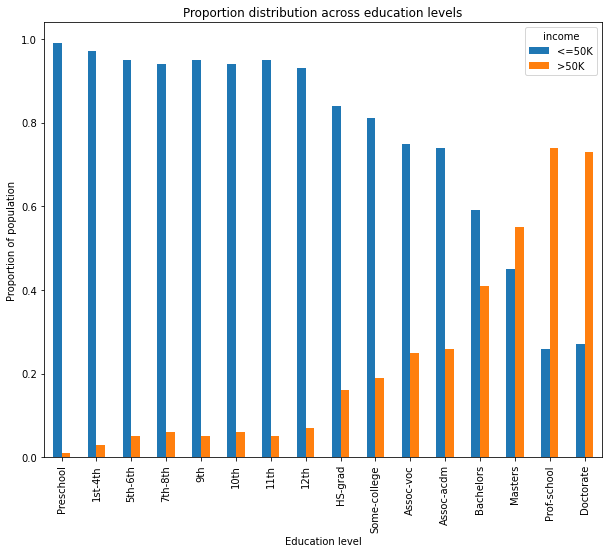

In [ ]:
printmd('## 2.1. Education vs Income')

education = round(pd.crosstab(adult.education, adult.income).div(pd.crosstab(adult.education, adult.income).apply(sum,1),0),2)
education = education.reindex(sorted(edu_level, key=edu_level.get, reverse=False))

ax = education.plot(kind ='bar', title = 'Proportion distribution across education levels', figsize = (10,8))
ax.set_xlabel('Education level')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across education levels \
        in the figure below. As one would expect, we see from the bar graph below that as the \
        education level increase, the proportion of people who earn more than 50k a year also \
        increase. It is interesting to note that only after a master\'s degree, the proportion of \
        people earning more than 50k a year, is a majority.')
        

## 2.2 Gender vs Income

We plot a bar graph showing the proportion of income classes across the genders in figure         below. From the graph, at an overall view, there exists a wage gap between females and males.         Since we do not have the exactly value of the income, we are limited to only observing that the         proportion of males earning more than 50k a year is more than double of their female counterparts.         

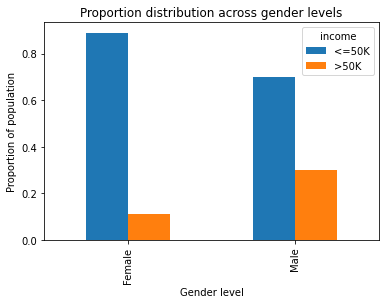

In [ ]:
printmd('## 2.2 Gender vs Income')

gender = round(pd.crosstab(adult.gender, adult.income).div(pd.crosstab(adult.gender, adult.income).apply(sum,1),0),2)
gender.sort_values(by = '>50K', inplace = True)
ax = gender.plot(kind ='bar', title = 'Proportion distribution across gender levels')
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('We plot a bar graph showing the proportion of income classes across the genders in figure \
        below. From the graph, at an overall view, there exists a wage gap between females and males. \
        Since we do not have the exactly value of the income, we are limited to only observing that the \
        proportion of males earning more than 50k a year is more than double of their female counterparts. \
        ')

Taking a closer look at the disparity in income between men and women, plot the         proportion of men and women who earn more than 50k a year, across all the working         classes as seen in Fig. 3. We see that men always have a higher proportion earning         more than 50k a year than women, except for the 'without.pay' working class, where         they have the same proportion.

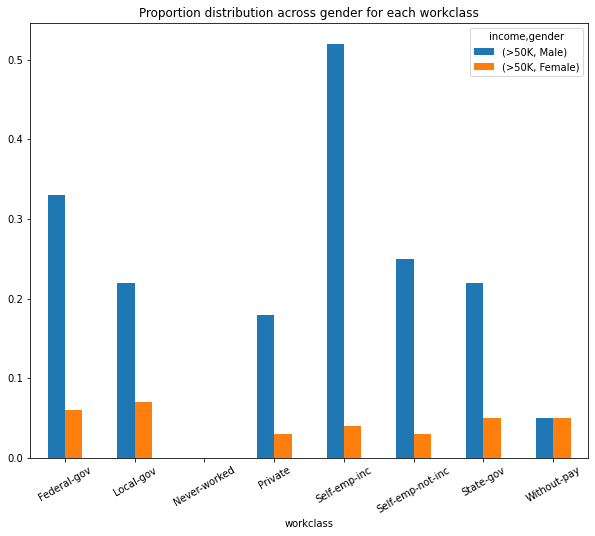

In [ ]:
gender_workclass = round(pd.crosstab(adult.workclass, [adult.income, adult.gender]).div(pd.crosstab(adult.workclass, [adult.income, adult.gender]).apply(sum,1),0),2)
gender_workclass[[('>50K','Male'), ('>50K','Female')]].plot(kind = 'bar', title = 'Proportion distribution across gender for each workclass', figsize = (10,8), rot = 30)
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('Taking a closer look at the disparity in income between men and women, plot the \
        proportion of men and women who earn more than 50k a year, across all the working \
        classes as seen in Fig. 3. We see that men always have a higher proportion earning \
        more than 50k a year than women, except for the \'without.pay\' working class, where \
        they have the same proportion.')

In [ ]:
# printmd('### Gender across working classes')

# for i in adult.workclass.unique():
#     df = adult[adult.workclass == i]

#     hours_per_week = round(pd.crosstab(df.gender, df.income).div(pd.crosstab(df.gender, df.income).apply(sum,1),0),2)
#     # hours_per_week.sort_values(by = '>50K', inplace = True)
#     ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Gender for '+ i)
#     ax.set_xlabel('Gender')
#     ax.set_ylabel('Proportion of population')

#     print()

## 2.3. Occupation vs Income

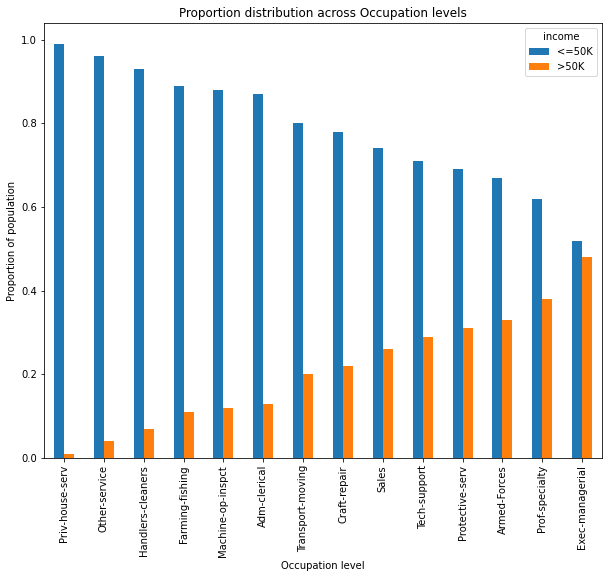

In [ ]:
printmd('## 2.3. Occupation vs Income')

occupation = round(pd.crosstab(adult.occupation, adult.income).div(pd.crosstab(adult.occupation, adult.income).apply(sum,1),0),2)
occupation.sort_values(by = '>50K', inplace = True)
ax = occupation.plot(kind ='bar', title = 'Proportion distribution across Occupation levels', figsize = (10,8))
ax.set_xlabel('Occupation level')
ax.set_ylabel('Proportion of population')

print()

## 2.4. Workclass vs Income

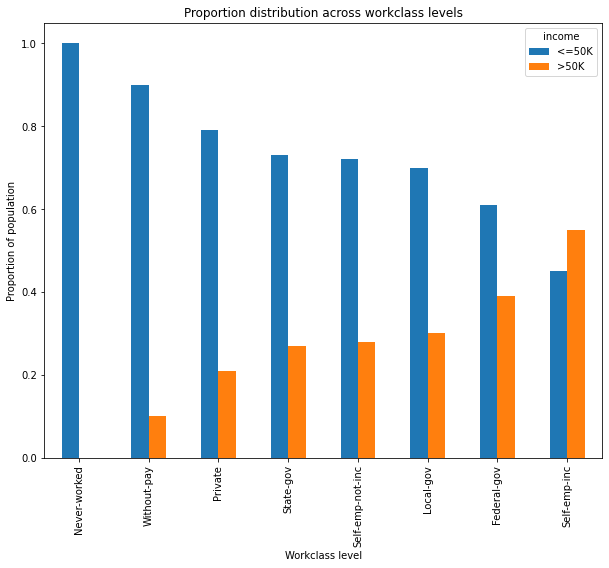

In [ ]:
printmd('## 2.4. Workclass vs Income')

workclass = round(pd.crosstab(adult.workclass, adult.income).div(pd.crosstab(adult.workclass, adult.income).apply(sum,1),0),2)
workclass.sort_values(by = '>50K', inplace = True)
ax = workclass.plot(kind ='bar', title = 'Proportion distribution across workclass levels', figsize = (10,8))
ax.set_xlabel('Workclass level')
ax.set_ylabel('Proportion of population')

print()

## 2.5. Race vs Income

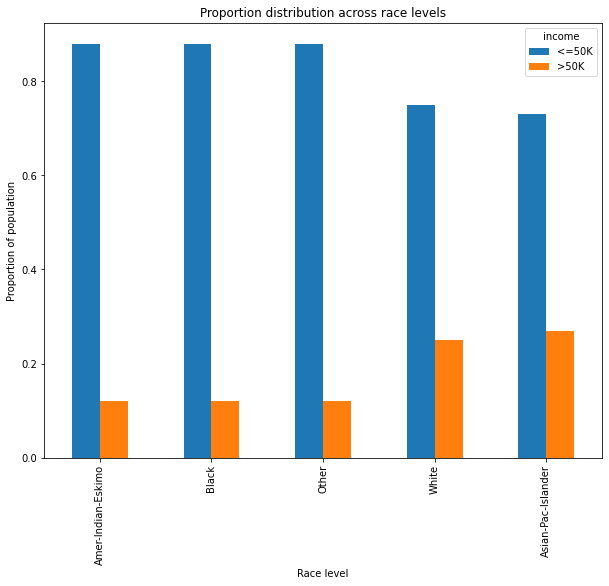

In [ ]:
printmd('## 2.5. Race vs Income')

race = round(pd.crosstab(adult.race, adult.income).div(pd.crosstab(adult.race, adult.income).apply(sum,1),0),2)
race.sort_values(by = '>50K', inplace = True)
ax = race.plot(kind ='bar', title = 'Proportion distribution across race levels', figsize = (10,8))
ax.set_xlabel('Race level')
ax.set_ylabel('Proportion of population')

print()

## 2.6. Native Country

I plot a bar graph showing the proportion of income classes across the native country in figure         below. From the graph, we notice a trend in positioning of the country. South American country are         at the left end of the plot, with low proportion of population that make more than 50k a year. The         United States is located somewhat centrally, and at the right are countries from Europe and Asia,         with higher proportion of population that make more than 50k a year.

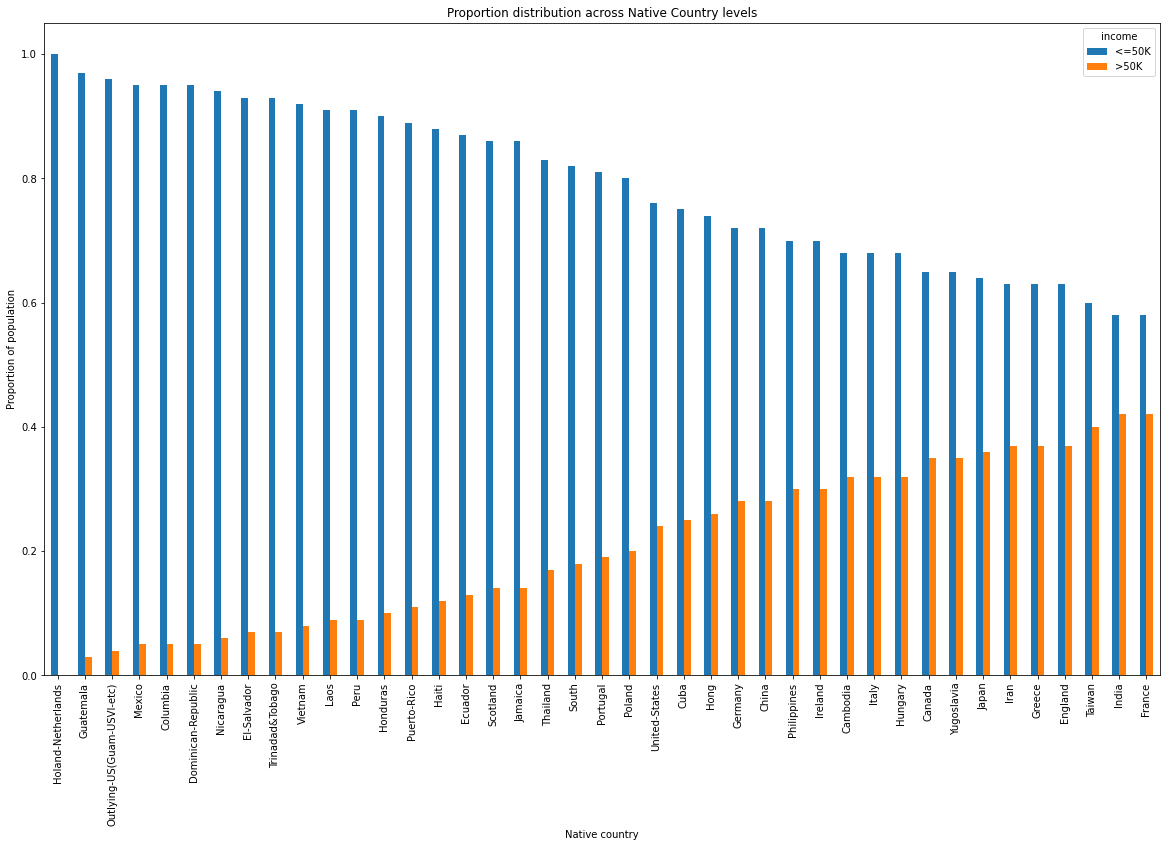

In [ ]:
printmd('## 2.6. Native Country')

native_country = round(pd.crosstab(adult['native-country'], adult.income).div(pd.crosstab(adult['native-country'], adult.income).apply(sum,1),0),2)
native_country.sort_values(by = '>50K', inplace = True)
ax = native_country.plot(kind ='bar', title = 'Proportion distribution across Native Country levels', figsize = (20,12))
ax.set_xlabel('Native country')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the native country in figure \
        below. From the graph, we notice a trend in positioning of the country. South American country are \
        at the left end of the plot, with low proportion of population that make more than 50k a year. The \
        United States is located somewhat centrally, and at the right are countries from Europe and Asia, \
        with higher proportion of population that make more than 50k a year.')


## 2.7. Hours per week vs Income

I plot a bar graph showing the proportion of income classes across the hours worked.         We would expected to notice a trend that higher the hours worked per week, the higher the proportion         of population making more than 50k a year. However, this was not necessarily true from the graph.         For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on)         no one earned more than 50k a year. 

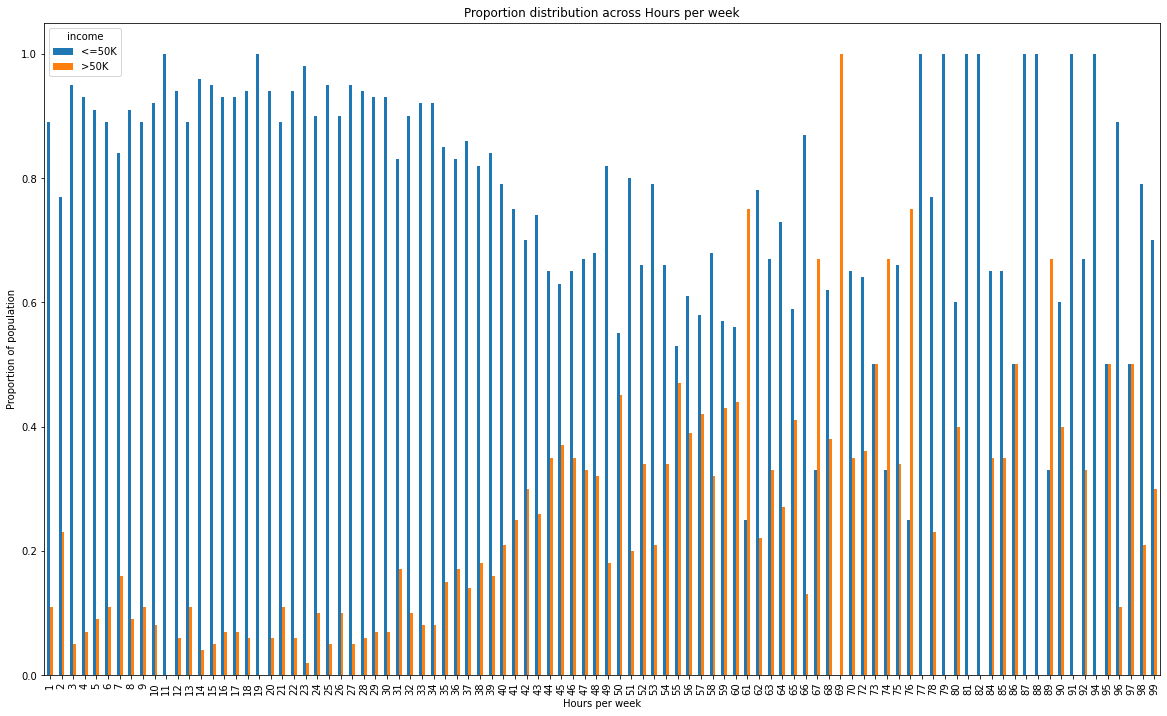

In [ ]:
printmd('## 2.7. Hours per week vs Income')

hours_per_week = round(pd.crosstab(adult['hours-per-week'], adult.income).div(pd.crosstab(adult['hours-per-week'], adult.income).apply(sum,1),0),2)
# hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (20,12))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the hours worked. \
        We would expected to notice a trend that higher the hours worked per week, the higher the proportion \
        of population making more than 50k a year. However, this was not necessarily true from the graph. \
        For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on) \
        no one earned more than 50k a year. ')


### 2.7.1 Hours per week with categories

Therefore, I decided to transform this column into 3 categories, less than 40 hours,         40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories,         we can see from the figure below that there is an increasing trend in the proportion of         population making more than 50k a year.

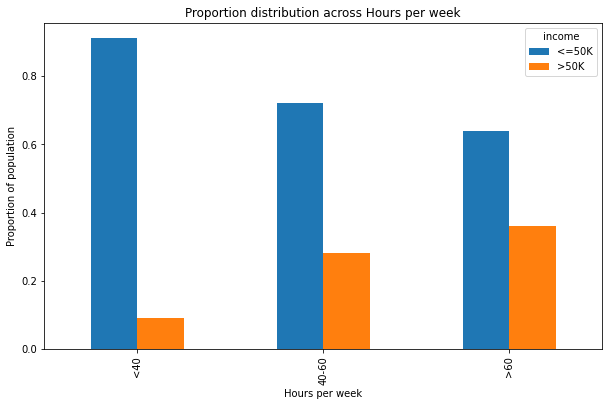

In [ ]:
printmd('### 2.7.1 Hours per week with categories')

adult['hour_worked_bins'] = ['<40' if i < 40 else '40-60' if i <= 60 else '>60'  for i in adult['hours-per-week']]
adult['hour_worked_bins'] = adult['hour_worked_bins'].astype('category')
hours_per_week = round(pd.crosstab(adult.hour_worked_bins, adult.income).div(pd.crosstab(adult.hour_worked_bins, adult.income).apply(sum,1),0),2)

hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (10,6))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('Therefore, I decided to transform this column into 3 categories, less than 40 hours, \
        40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories, \
        we can see from the figure below that there is an increasing trend in the proportion of \
        population making more than 50k a year.')


### 2.7.2 Hours worked across working classes

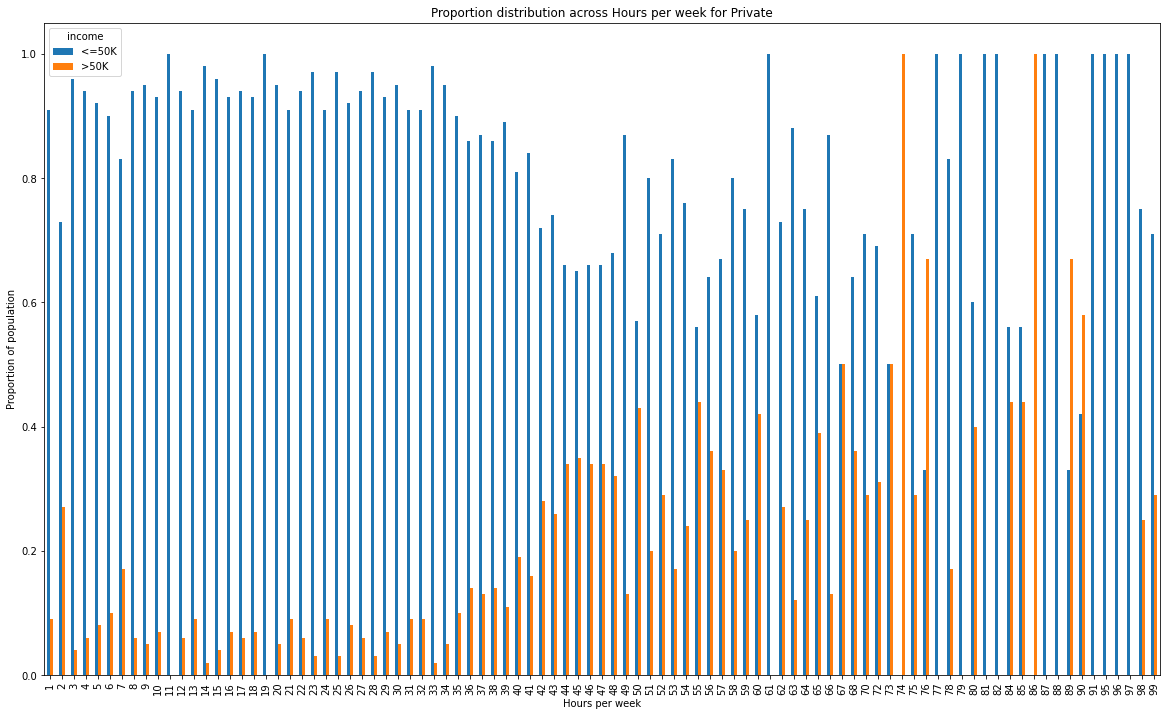

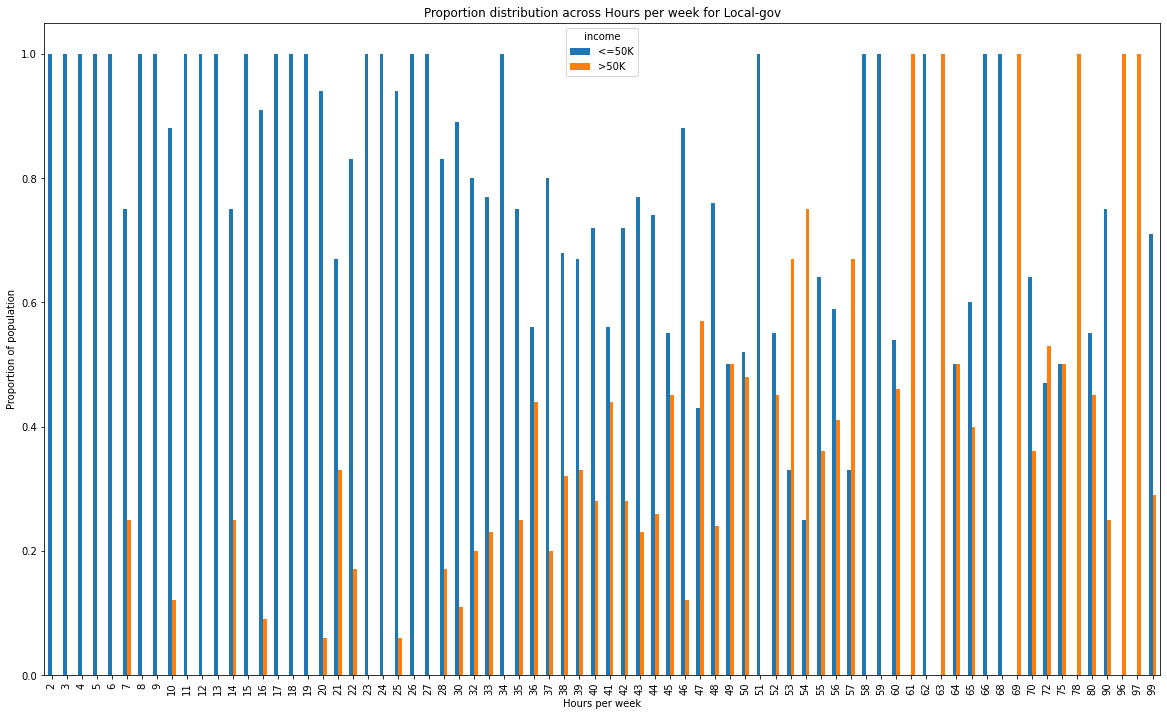

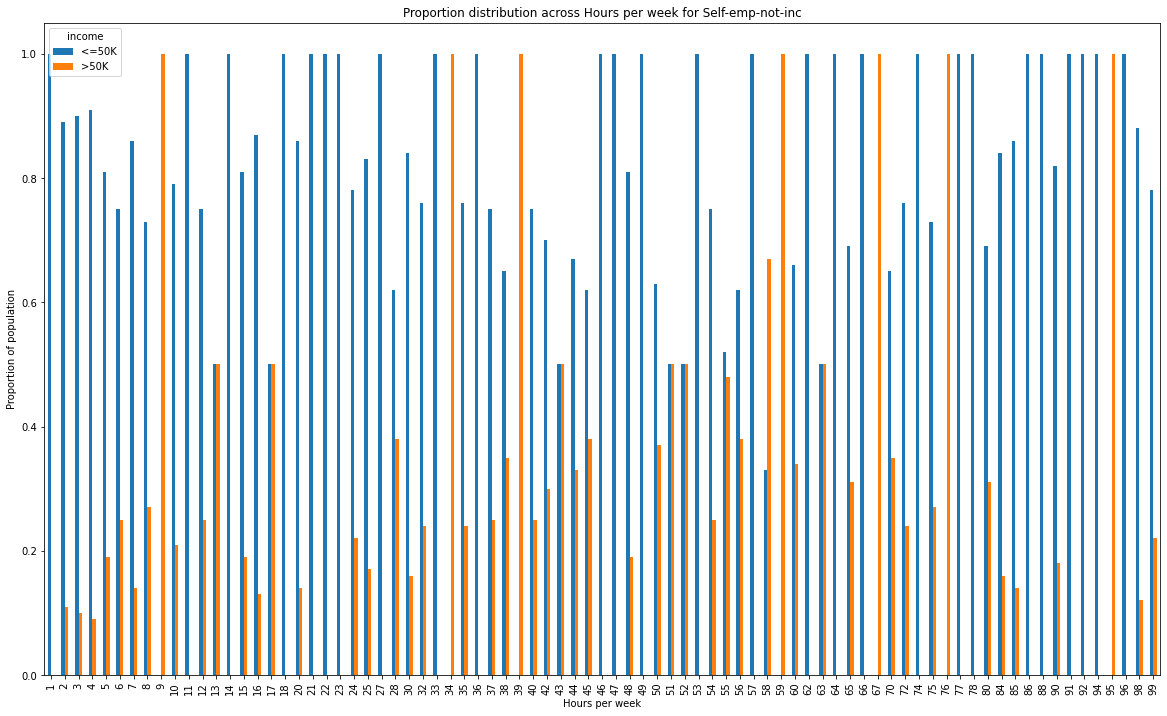

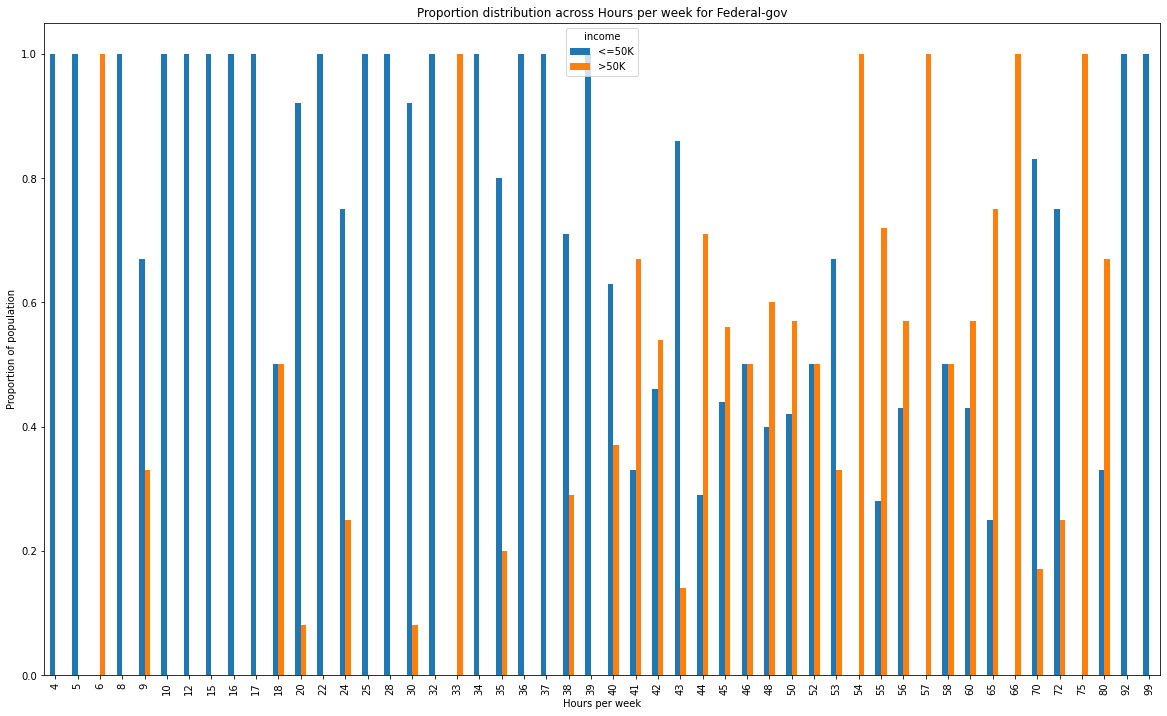

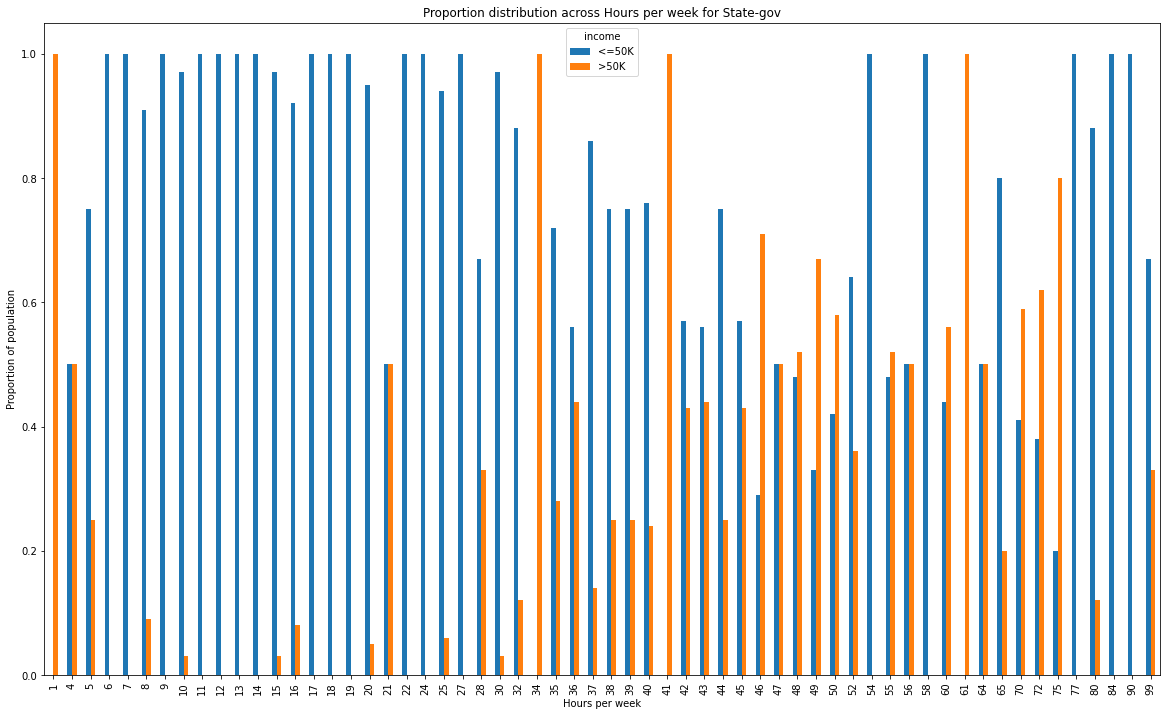

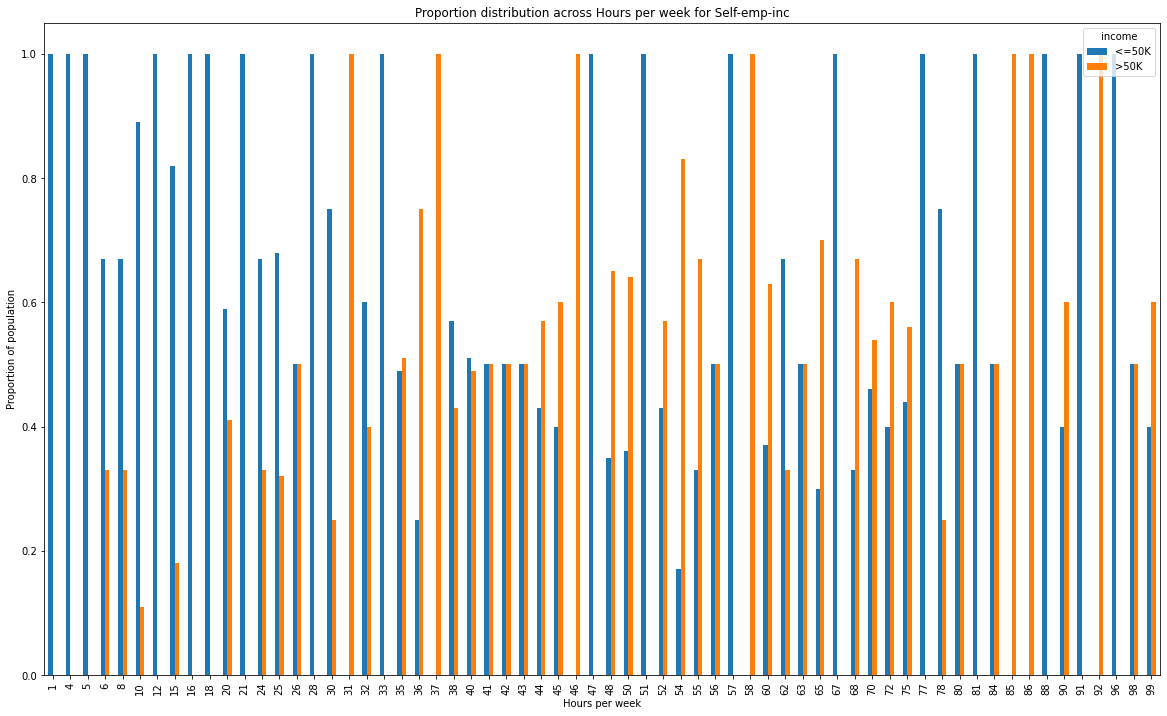

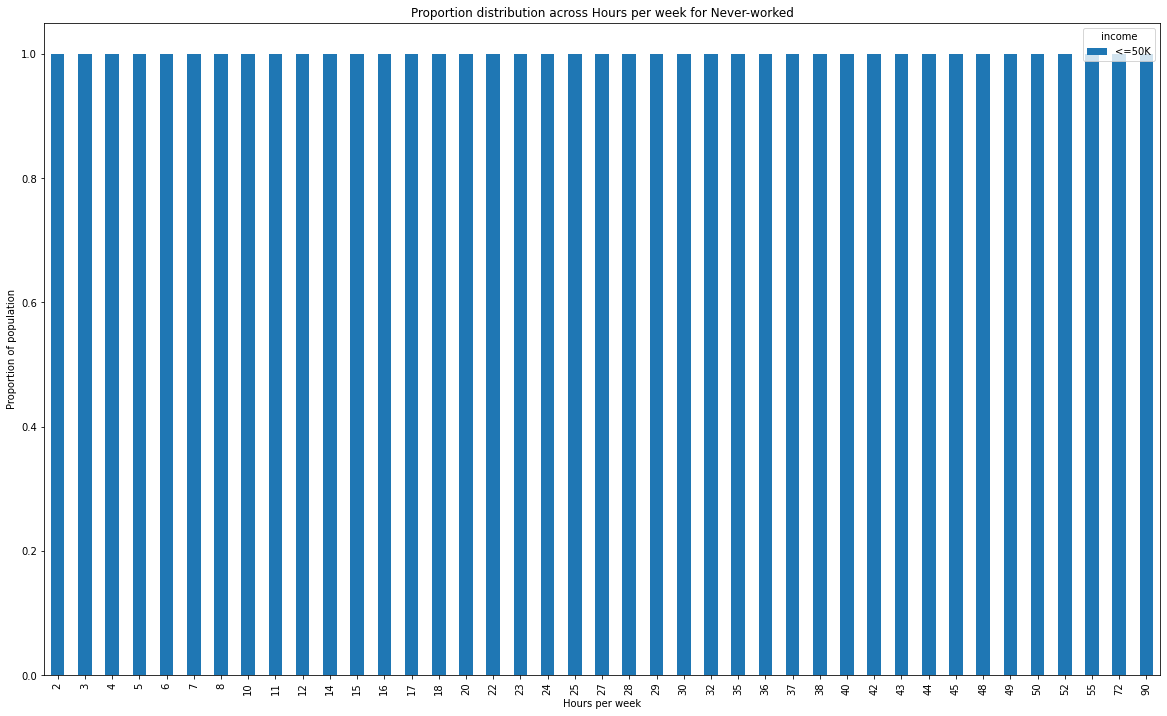

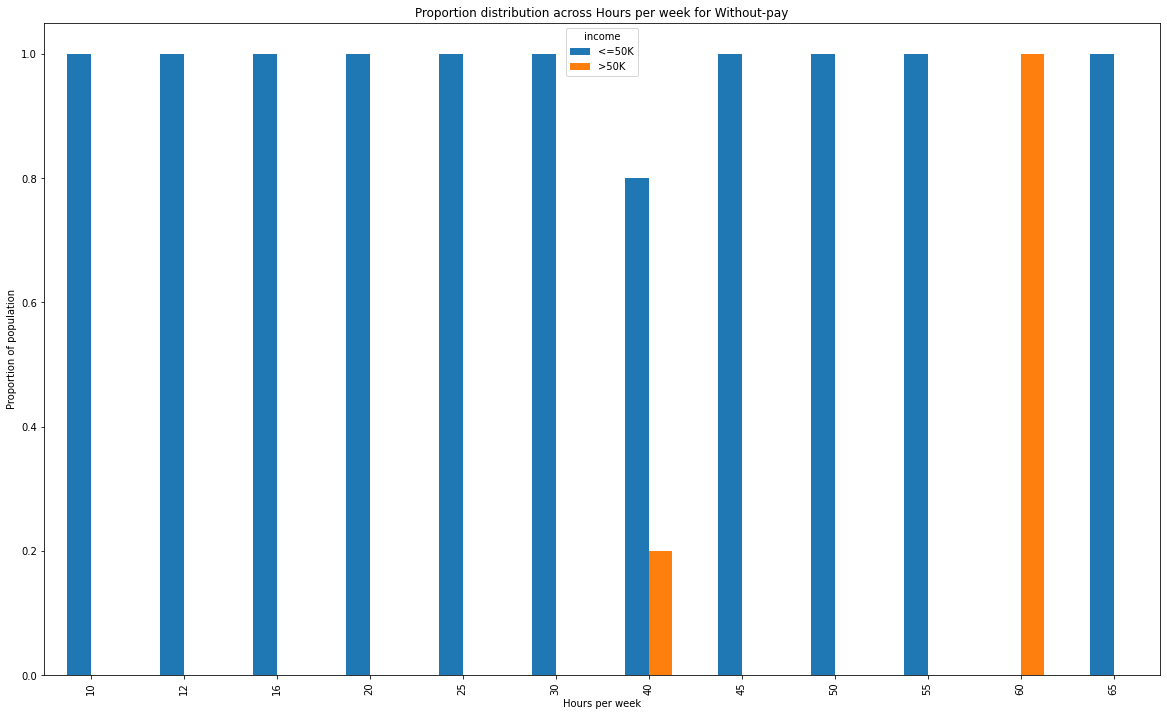

In [ ]:
printmd('### 2.7.2 Hours worked across working classes')

for i in adult.workclass.unique():
    df = adult[adult.workclass == i]

    hours_per_week = round(pd.crosstab(df['hours-per-week'], df.income).div(pd.crosstab(df['hours-per-week'], df.income).apply(sum,1),0),2)
    # hours_per_week.sort_values(by = '>50K', inplace = True)
    ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week for '+ i, figsize = (20,12))
    ax.set_xlabel('Hours per week')
    ax.set_ylabel('Proportion of population')

    print()

In [ ]:
# plt.rcParams['figure.figsize'] = (5, 4)
# #plt.xlim([20,110])
# #plt.ylim([20,110])
            
# pos = adult[adult.income == '>50K']
# neg = adult[adult.income != '>50K']


# plt.scatter(pos['educational-num'], pos['hours-per-week'], marker='o', c='b')
# plt.scatter(neg['educational-num'], neg['hours-per-week'], marker='x', c='r')
# plt.xlabel('Exam 1 score')
# plt.ylabel('Exam 2 score')
# plt.legend(['Not Admitted', 'Admitted'])

# plt.show()

---
# 3. Data Transformations

## 3.1. Feature Selection

In [ ]:
# Remove education and fnlwgt
#adult.drop(columns = ['education','fnlwgt','hours-per-week'], inplace = True)

printmd('* For education level, we have 2 features that convey the same meaning, \'education\' \
        and \'educational-num\'. To avoid the effect of this attribute on the models to be \
        overstated, I am not going to use the categorical education attribute.')
printmd('* I use the categorical Hours work column and drop the \'hour-per-week\' column')
printmd('* Also, I chose not to use the \'Fnlwgt\' attribute that is used by the census, \
        as the inverse of sampling fraction adjusted for non-response and over or under sampling \
        of particular groups. This attribute does not convey individual related meaning.')


* For education level, we have 2 features that convey the same meaning, 'education'         and 'educational-num'. To avoid the effect of this attribute on the models to be         overstated, I am not going to use the categorical education attribute.

* I use the categorical Hours work column and drop the 'hour-per-week' column

* Also, I chose not to use the 'Fnlwgt' attribute that is used by the census,         as the inverse of sampling fraction adjusted for non-response and over or under sampling         of particular groups. This attribute does not convey individual related meaning.

## 3.2 Normalization

## Box plot

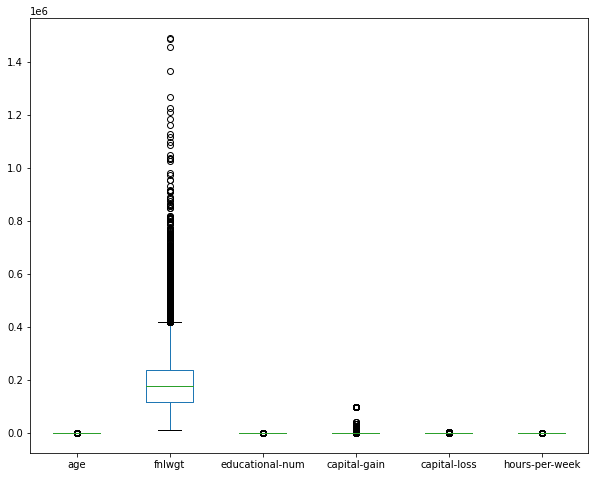

In [ ]:
printmd('## Box plot')
adult.select_dtypes(exclude = 'category').plot(kind = 'box', figsize = (10,8))

In [ ]:
printmd ('Normalization happens on the training dataset, by removing the mean and \
        scaling to unit variance. These values are stored and then later applied  \
        to the test data before the test data is passed to the model for prediction. ')

Normalization happens on the training dataset, by removing the mean and         scaling to unit variance. These values are stored and then later applied          to the test data before the test data is passed to the model for prediction. 

---
# 4. Model Development & Classification 

## 4.1. Data Preparation'

One-hot encoding is the process of representing multi-class categorical features as binary features, one for each class. Although this process increases the dimensionality of the dataset, classification algorithms tend to work better on this format of data.

I use one-hot encoding to represent all the categorical features in the dataset. 


In [ ]:
# Data Prep
adult_data = adult.drop(columns = ['income'])
adult_label = adult.income


adult_cat_1hot = pd.get_dummies(adult_data.select_dtypes('category'))
adult_non_cat = adult_data.select_dtypes(exclude = 'category')

adult_data_1hot = pd.concat([adult_non_cat, adult_cat_1hot], axis=1, join='inner')


In [ ]:
# Train - Test split
train_data, test_data, train_label, test_label = train_test_split(adult_data_1hot, adult_label, test_size  = 0.25)

In [ ]:
# Normalization
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Fitting only on training data
scaler.fit(train_data)  
train_data = scaler.transform(train_data)  

# Applying same transformation to test data
test_data = scaler.transform(test_data) 

In [ ]:
def model_eval(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc['>50K','>50K']
    TN = confusion.loc['<=50K','<=50K']
    FP = confusion.loc['<=50K','>50K']
    FN = confusion.loc['>50K','<=50K']

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out


## 4.2. Model Development
### 4.2.1. Decision Tree

For the decision tree classifier, I experimented with the splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Splitting criteria:** Gini Index (Using Gini Index marginally outperformed Entropy with a higher accuracy.)
*	**Min samples required to split:** 5% (Best amongst 1%, 10% and 5%.)
*	**Max Depth:** None
*	**Min samples required at leaf:**  0.1 % (Best amongst 1%, 5% and 0.1%.)
*	**Max features:** number of features (Performs better than 'auto', 'log2' and 'sqrt'.)


In [ ]:
#printmd('### 3.1.1. Model Development ')

# Gini 
clf_gini = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_split = 0.05, min_samples_leaf = 0.001, max_features = None)
clf_gini = clf_gini.fit(train_data, train_label)
clf_gini_pred = clf_gini.predict(test_data)
DTree_Gini = model_eval(test_label, clf_gini_pred)
print('Desicion Tree using Gini Index : %.2f percent.' % (round(DTree_Gini['accuracy']*100,2)))


# Entropy
clf_entropy = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 0.05, min_samples_leaf = 0.001)
clf_entropy = clf_entropy.fit(train_data, train_label)
clf_entropy_pred = clf_entropy.predict(test_data)
DTree_Entropy = model_eval(test_label, clf_entropy_pred)
print('Desicion Tree using Entropy : %.2f percent.' % (round(DTree_Entropy['accuracy']*100,2)))


#printmd('### 3.1.2. Model Evaulation ')
ovl_dtree = round(pd.DataFrame([DTree_Entropy, DTree_Gini], index = ['DTree_Entropy','DTree_Gini']),4)
display(ovl_dtree)

Desicion Tree using Gini Index : 85.63 percent.
Desicion Tree using Entropy : 85.74 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
DTree_Entropy,0.8574,0.7896,0.5362,0.6387,0.5362,0.9561,0.1426
DTree_Gini,0.8563,0.7734,0.5495,0.6425,0.5495,0.9505,0.1437


In [ ]:
# Plot tree

# from sklearn.tree import export_graphviz
# from IPython.display import SVG
# from graphviz import Source



# graph = Source( tree.export_graphviz(clf, out_file=None, feature_names=train_data.columns))

# # Display Tree
# SVG(graph.pipe(format='svg'))

# # Save Tree as PNG
# png_bytes = graph.pipe(format='png')
# with open('dtree_pipe.png','wb') as f:
#     f.write(png_bytes)

### 4.2.2. Artificial Neural Network
For the ANN classifier, I experimented with the activation function, the solver for weight optimization, regularization term and learning schedule for weight updates. The following values of the parameters attained the best accuracy during classification. Other parameters were neither applicable to the 'adam' solver nor did it improve the performance of the model. Results in the table below.

*	**Activation:** Logistic (Marginally outperformed 'relu', 'tanh' and 'identity' functions.)
*   **Solver:** Adam (Works well on relatively large datasets with thousands of training samples or more)
*   **Alpha:** 1e-4 (Best amongst 1, 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5)
*   **Learning Rate:**  'invscaling' (Gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'.)


In [ ]:
# Tan H
ann_tanh = MLPClassifier(activation = 'tanh', solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(10, 2), random_state=1, warm_start=True)
ann_tanh.fit(train_data, train_label)                         
ann_tanh_pred = ann_tanh.predict(test_data)
ANN_TanH = model_eval(test_label, ann_tanh_pred)
print('ANN using TanH and lbfgs solver : %.2f percent.' % (round(ANN_TanH['accuracy']*100,2)))


# Relu
ann_relu = MLPClassifier(activation = 'relu', solver='adam', alpha=1e-1, 
                    hidden_layer_sizes=(5, 2), random_state=1,
                    learning_rate  = 'invscaling',
                    warm_start = True)
ann_relu.fit(train_data, train_label)                         
ann_relu_pred = ann_relu.predict(test_data)
ANN_relu = model_eval(test_label, ann_relu_pred)
print('ANN using relu and adam solver : %.2f percent.' % (round(ANN_relu['accuracy']*100,2)))

# Log
ann_log = MLPClassifier(activation = 'logistic', solver='adam', 
                    alpha=1e-4, hidden_layer_sizes=(5, 2),
                    learning_rate  = 'invscaling', 
                    random_state=1, warm_start = True)
ann_log.fit(train_data, train_label)                         
ann_log_pred = ann_log.predict(test_data)
ANN_log = model_eval(test_label, ann_log_pred)
print('ANN using logistic and adam solver : %.2f percent.' % (round(ANN_log['accuracy']*100,2)))

# Identity
ann_identity = MLPClassifier(activation = 'identity', solver='adam', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=1, warm_start = True)
ann_identity.fit(train_data, train_label)                         
ann_identity_pred = ann_identity.predict(test_data)
ANN_identity = model_eval(test_label, ann_identity_pred)
print('ANN using identity and adam solver : %.2f percent.' % (round(ANN_identity['accuracy']*100,2)))

#printmd('### 3.2.2. Model Evaulation ')
ovl_ann = round(pd.DataFrame([ANN_TanH, ANN_relu, ANN_log, ANN_identity], index = ['ANN_TanH','ANN_relu', 'ANN_log', 'ANN_identity']),4)
display(ovl_ann)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ANN using TanH and lbfgs solver : 84.99 percent.
ANN using relu and adam solver : 85.46 percent.
ANN using logistic and adam solver : 85.21 percent.
ANN using identity and adam solver : 85.14 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
ANN_TanH,0.8499,0.7121,0.6066,0.6551,0.6066,0.9246,0.1501
ANN_relu,0.8546,0.7216,0.6206,0.6673,0.6206,0.9265,0.1454
ANN_log,0.8521,0.7135,0.6195,0.6632,0.6195,0.9236,0.1479
ANN_identity,0.8514,0.7253,0.5916,0.6517,0.5916,0.9312,0.1486


### 4.2.3. Support Vector Machine
For the SVM classifier, I experimented with the various available kernels, the penalty of the error term and the tolerance for stopping criteria. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Kernel:** rbf (Marginally outperformed 'linear, 'poly' and 'sigmoid' kernels.)
*	**C, penalty of the error term:** 1 (Best amongst 0.1, 0.5, 1 and 10)
*	**Tolerance for stopping criteria:** 1e-3 (Best amongst 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5)


In [ ]:
# rbf kernal
svm_clf_rbf = svm.SVC(kernel = 'rbf', C = 1, tol = 1e-3)
svm_clf_rbf.fit(train_data, train_label)
svm_clf_rbf_pred = svm_clf_rbf.predict(test_data)
SVM_rbf = model_eval(test_label, svm_clf_rbf_pred)
print('SVM using rbf kernel : %.2f percent.' % (round(SVM_rbf['accuracy']*100,2)))

# Linear kernel
svm_clf_linear = svm.SVC(kernel = 'linear')
svm_clf_linear.fit(train_data, train_label)
svm_clf_linear_pred = svm_clf_linear.predict(test_data)
SVM_linear = model_eval(test_label, svm_clf_linear_pred)
print('SVM using linear kernel : %.2f percent.' % (round(SVM_linear['accuracy']*100,2)))


# Poly kernal
svm_clf_poly = svm.SVC(kernel = 'poly')
svm_clf_poly.fit(train_data, train_label)
svm_clf_poly_pred = svm_clf_poly.predict(test_data)
SVM_poly = model_eval(test_label, svm_clf_poly_pred)
print('SVM using poly kernel : %.2f percent.' % (round(SVM_poly['accuracy']*100,2)))


svm_clf_sigmoid = svm.SVC(kernel = 'sigmoid')
svm_clf_sigmoid.fit(train_data, train_label)
svm_clf_sigmoid_pred = svm_clf_sigmoid.predict(test_data)
SVM_sigmoid = model_eval(test_label, svm_clf_sigmoid_pred)
print('SVM using sigmoid kernel : %.2f percent.' % (round(SVM_sigmoid['accuracy']*100,2)))



#printmd('### 3.3.2. Model Evaulation ')
ovl_svm = round(pd.DataFrame([SVM_rbf, SVM_linear, SVM_poly, SVM_sigmoid], index = ['SVM_rbf','SVM_linear', 'SVM_poly', 'SVM_sigmoid']),4)
display(ovl_svm)

SVM using rbf kernel : 85.47 percent.
SVM using linear kernel : 85.23 percent.
SVM using poly kernel : 83.83 percent.
SVM using sigmoid kernel : 81.98 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
SVM_rbf,0.8547,0.7466,0.5780,0.6516,0.5780,0.9397,0.1453
SVM_linear,0.8523,0.7355,0.5805,0.6489,0.5805,0.9359,0.1477
SVM_poly,0.8383,0.7276,0.4990,0.5920,0.4990,0.9426,0.1617
SVM_sigmoid,0.8198,0.6309,0.5617,0.5943,0.5617,0.8990,0.1802


### 4.2.4. Ensemble Models

### 4.2.4.1. Random Forest
For the random forests classifier, I experimented with the number of trees, splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Num estimators:** 100 (Best amongst 10, 50 and 100)
*	**Splitting criteria:** Gini Index (Using Gini Index marginally outperformed Entropy with a higher accuracy.)
*	**Min samples required to split:** 5% (Best amongst 1%, 10% and 5%.)
*	**Max Depth:** None
*	**Min samples required at leaf:**  0.1 % (Best amongst 1%, 5% and 0.1%.)
*	**Max features:** number of features (Performs better than 'auto', 'log2' and 'sqrt'.)


In [ ]:
# Gini
r_forest_gini = RandomForestClassifier(n_estimators=100, criterion = 'gini', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
r_forest_gini.fit(train_data, train_label)
r_forest_gini_pred = r_forest_gini.predict(test_data)
rforest_gini = model_eval(test_label, r_forest_gini_pred)
print('Random Forest using Gini Index : %.2f percent.' % (round(rforest_gini['accuracy']*100,2)))

# Entropy
r_forest_entropy = RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
r_forest_entropy.fit(train_data, train_label)
r_forest_entropy_pred = r_forest_entropy.predict(test_data)
rforest_entropy = model_eval(test_label, r_forest_entropy_pred)
print('Random Forest using Entropy : %.2f percent.' % (round(rforest_entropy['accuracy']*100,2)))

#printmd('### 3.4.1.2. Model Evaulation ')
ovl_rf = round(pd.DataFrame([rforest_gini, rforest_entropy], index = ['rforest_gini','rforest_entropy']),4)
display(ovl_rf)

Random Forest using Gini Index : 85.60 percent.
Random Forest using Entropy : 85.62 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
rforest_gini,0.8560,0.7742,0.5470,0.6411,0.5470,0.9510,0.1440
rforest_entropy,0.8562,0.7752,0.5467,0.6412,0.5467,0.9513,0.1438


### 4.2.4.2. Adaboost
For the adaboost classifier, I experimented with base estimator from which the boosted ensemble is built and number of estimators. The following values of the parameters attained the best accuracy during classification. Results in the table below.

*	**Base Estimator:** DecisionTreeClassifier
*	**Num estimators:** 100 (Best amongst 10, 50 and 100.)


In [ ]:
ada = AdaBoostClassifier(n_estimators=100)                     
ada.fit(train_data, train_label)
ada_pred = ada.predict(test_data)
adaboost = model_eval(test_label, ada_pred)
print('Adaboost : %.2f percent.' % (round(adaboost['accuracy']*100,2)))

#printmd('### 3.4.2.2. Model Evaulation ')
ovl_ada = round(pd.DataFrame([adaboost], index = ['adaboost']),4)
display(ovl_ada)

Adaboost : 86.33 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
adaboost,0.8633,0.7596,0.6122,0.678,0.6122,0.9405,0.1367


### 4.2.5. Logistic Regression

In [ ]:
log_reg = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, 
                            solver = 'liblinear')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)
logistic_reg = model_eval(test_label, log_reg_pred)
print('Logistic Regression : %.2f percent.' % (round(logistic_reg['accuracy']*100,3)))

#printmd('### 3.5.2. Model Evaulation ')
ovl_logreg = round(pd.DataFrame([logistic_reg], index = ['logistic_reg']),4)
display(ovl_logreg)

Logistic Regression : 85.23 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
logistic_reg,0.8523,0.7289,0.592,0.6533,0.592,0.9323,0.1477


### 4.2.6. k Nearest Neighbours
For the K nearest neighbours classifier, I experimented with the num of neighbours values, every odd number ranging from 1 to 50.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_outs = []
for i in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_data, train_label) 
    knn_pred = knn.predict(test_data)
    knn_perf = model_eval(test_label, knn_pred)
    knn_perf['k'] = i
    knn_outs.append(knn_perf)

ovl_knn = round(pd.DataFrame(knn_outs),4)
display(ovl_knn)

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate,k
0,0.7957,0.5676,0.5484,0.5579,0.5484,0.8716,0.2043,1
1,0.8191,0.6316,0.5526,0.5895,0.5526,0.9010,0.1809,3
2,0.8293,0.6596,0.5652,0.6087,0.5652,0.9104,0.1707,5
3,0.8300,0.6615,0.5666,0.6104,0.5666,0.9109,0.1700,7
4,0.8308,0.6668,0.5599,0.6087,0.5599,0.9140,0.1692,9
5,0.8324,0.6738,0.5564,0.6095,0.5564,0.9172,0.1676,11
6,0.8333,0.6774,0.5554,0.6104,0.5554,0.9187,0.1667,13
7,0.8338,0.6780,0.5575,0.6119,0.5575,0.9186,0.1662,15
8,0.8333,0.6749,0.5613,0.6129,0.5613,0.9169,0.1667,17
9,0.8359,0.6819,0.5655,0.6183,0.5655,0.9190,0.1641,19


---
# 5. Model Evaluation
## 5.1. Overall Performance Statistics

In [ ]:
overall_eval = pd.concat([ovl_dtree, ovl_ann, ovl_svm, ovl_rf, ovl_ada, ovl_logreg], axis = 0)
overall_eval.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)

printmd('Combing the performance statistics of all the model developed, as seen in table below, \
        we see that the ensemble model Adaboost hast the highest F-measure (0.6833), precision (0.7812) \
        and accuracy (0.8647). The Artificial neural network models are only marginally being in terms of \
        accuracy and F-measure. Almost all the model have an accuracy greater than 0.84, expect for two SVM \
        models. The table below lists the accuracy, error rate, F-measure, precision, recall, sensitivity and \
        specificity of all the models developed.')

display(overall_eval)

Combing the performance statistics of all the model developed, as seen in table below,         we see that the ensemble model Adaboost hast the highest F-measure (0.6833), precision (0.7812)         and accuracy (0.8647). The Artificial neural network models are only marginally being in terms of         accuracy and F-measure. Almost all the model have an accuracy greater than 0.84, expect for two SVM         models. The table below lists the accuracy, error rate, F-measure, precision, recall, sensitivity and         specificity of all the models developed.

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
adaboost,0.8633,0.7596,0.6122,0.6780,0.6122,0.9405,0.1367
ANN_relu,0.8546,0.7216,0.6206,0.6673,0.6206,0.9265,0.1454
ANN_log,0.8521,0.7135,0.6195,0.6632,0.6195,0.9236,0.1479
ANN_TanH,0.8499,0.7121,0.6066,0.6551,0.6066,0.9246,0.1501
logistic_reg,0.8523,0.7289,0.5920,0.6533,0.5920,0.9323,0.1477
ANN_identity,0.8514,0.7253,0.5916,0.6517,0.5916,0.9312,0.1486
SVM_rbf,0.8547,0.7466,0.5780,0.6516,0.5780,0.9397,0.1453
SVM_linear,0.8523,0.7355,0.5805,0.6489,0.5805,0.9359,0.1477
DTree_Gini,0.8563,0.7734,0.5495,0.6425,0.5495,0.9505,0.1437
rforest_entropy,0.8562,0.7752,0.5467,0.6412,0.5467,0.9513,0.1438


## 5.2. ROC Curve

In [ ]:
def generateRoc(test_data, test_label, classifiers, pred_labels, plot_labels, limiter):
    
    color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    
    y_test = label_binarize(test_label, classes=['<=50K', '>50K'])
    plt.figure()
    
    for i in range(len(classifiers)):
        
        if plot_labels[i] not in limiter:
            continue
        
        y_score = classifiers[i].predict_proba(test_data)
        pos_class_index = list(np.unique(pred_labels[i])).index('>50K')
        
        fpr, tpr, thres = metrics.roc_curve(y_test.ravel(),y_score[:,pos_class_index], pos_label=1)
                               
        lw = 2
        plt.plot(fpr, tpr, color=color[i % len(color)],lw=lw, label=plot_labels[i])
        
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
%matplotlib notebook
classifier_list = [clf_gini
                ,clf_entropy
                ,ann_tanh
                ,ann_relu
                ,ann_log
                ,ann_identity
#                 ,svm_clf_rbf
#                 ,svm_clf_linear
#                 ,svm_clf_poly
#                 ,svm_clf_sigmoid
                ,r_forest_gini
                ,r_forest_entropy
                ,ada
                ,log_reg
                ] 
pred_list = [clf_gini_pred
            ,clf_entropy_pred
            ,ann_tanh_pred
            ,ann_relu_pred
            ,ann_log_pred
            ,ann_identity_pred
#             ,svm_clf_rbf_pred
#             ,svm_clf_linear_pred
#             ,svm_clf_poly_pred
#             ,svm_clf_sigmoid_pred
            ,r_forest_gini_pred
            ,r_forest_entropy_pred
            ,ada_pred
            ,log_reg_pred
            ]

clf_labels = ['DTree Gini'
            ,'DTree Entropy'
            ,'ANN TanH'
            ,'ANN relu'
            ,'ANN Logistic'
            ,'ANN Identity'
#             ,svm_clf_rbf_pred
#             ,svm_clf_linear_pred
#             ,svm_clf_poly_pred
#             ,svm_clf_sigmoid_pred
            ,'RForest Gini'
            ,'RForest Entropy'
            ,'Adaboost'
            ,'Logistic Regression'
            ]

limiter = ['Adaboost', 'ANN TanH', 'ANN relu', 'ANN Logistic', 'Logistic Regression']
generateRoc(test_data, test_label, classifier_list, pred_list, clf_labels, limiter)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The plot above of the receiver operating characteristic curve for the top 5 models; Adaboost, ANN with logistics activation function, ANN with relu activation function, ANN with tanH activation function and logistic regression model. I chose to plot only the top 5 models as the ROC curves of most of the models overlap and the it is not easy to interpret the curve. 

From figure, we can see that the ROC curve of the Adaboost model has the highest lift and is closest to the top left corner (TPR of 1 and FPR of 0) of the plot. The Adaboost model's curve clearly separates itself from the ROC curves of the other 4 models, which overlap with each other. 

---
# 5. Conclusion

I choose **Adaboost** model as my preferred my approach. The Adaboost model not only has the **highest accuracy**, but also has the **highest precision and F-measure** of all the models developed as a part of this analysis. The advantages of using Adaboost over other models is that they are very simple to implement. Since they are made up of weak individual learners, they are less susceptible to overfitting. However, Adaboost is sensitive to noisy data and outliers. 
